# Easy 21 problem

I haven't been to the UCL therefore I can't know if my answers would satisfy the one that created and corrected [this subject](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/Easy21-Johannes.pdf) however I found it quite interesting. Here are my answers to its questions

In [2]:
#Imports and utils functions

import numpy as np
import random
import math
import matplotlib.pyplot as plt
from functools import wraps
from tqdm import tqdm

#utils function to get an integer if the value is between inf and sup
def inbetween(value,inf,sup):
    if value <=sup and value >= inf:
        return 1
    else:
        return 0


## Implementation of easy 21

In [4]:
#Environement class 
class Easy21(object):
    """
    Implementation of Easy 21 a simplified Black jack
    This was an exercice for the students following UCL course on RL
    You have two actions hit or draw the closest to 21 between the dealer and the player wins
    """
    def __init__(self):
        self.max_value=10
        self.dealer_card = random.randint(1,self.max_value)
        self.initial_card = random.randint(1,self.max_value)
        self.count = self.initial_card
        self.action_space=2
        self.state_space=2
    #classic state has the dealer card and the current count
    @property
    def state(self):
        return [self.dealer_card,self.count]
    # binary state has overlapping features made for a binary linear model
    @property
    def binary_state(self):
        dealer_binary = np.array([inbetween(self.dealer_card,1,4),inbetween(self.dealer_card,4,7),inbetween(self.dealer_card,7,10)])
        player_binary = np.array([inbetween(self.count,1,6),inbetween(self.count,4,9),inbetween(self.count,7,12),inbetween(self.count,10,15),inbetween(self.count,13,18),inbetween(self.count,16,21)])
        return np.concatenate((dealer_binary,player_binary),axis=0)
    
    #function to draw a card
    def pull(self):
        return random.choice([1,-1])*random.randint(1,self.max_value)
    
    #first action is to pull second action to hit
    def step(self,action):
        if action == 0:
            self.count += self.pull()
            if self.count >21 or self.count<1:
                new_state, reward, done =  None,-1,True
            else:
                new_state, reward, done = self.state,0,False
            return new_state, reward, done
        #if you hit the dealer pulls until he has lost (=less than 1 or above 21) or above 17
        #in the latter case the number is then compared to the number that we pulled
        if action == 1:
            dealers_sum = self.dealer_card
            while True:
                dealers_sum += self.pull()
                if dealers_sum<1 or dealers_sum>21:
                    new_state, reward, done  = None,1,True
                    return new_state, reward, done
                if dealers_sum >=17:
                    if dealers_sum < self.count:
                        reward = 1
                    if dealers_sum == self.count:
                        reward = 0
                    if dealers_sum > self.count:
                        reward = -1
                    new_state, reward, done = None, reward, True
                    return new_state, reward, done

    #reboot function
    def restart(self):
        self.dealer_card = random.randint(1,self.max_value)
        self.initial_card = random.randint(1,self.max_value)
        self.count = self.initial_card
        return self.state



## Monte-Carlo Control

In [9]:

#Epsilon greedy agent with a Q table
class AgentEpsilonTable(object):
    def __init__(self,actions_number,dealer_range,player_range,n0):
        #the Q table has the dimension of the state [1,10]x[1,21] time the dim of the action [0,1]
        self.q_table = np.zeros((dealer_range,player_range,actions_number))
        #for averaging the Q values sampled 
        self.count = np.zeros((dealer_range,player_range,actions_number))
        #epsilon will depend on this parameter
        self.n0 = n0
        self.actions_number = actions_number

    # function to select an action in the epsilon greedy manner
    def select_action(self,state):
        epsilon = self.n0/(self.n0 + np.sum(self.count[state[0]-1,state[1]-1]))
        if random.random() < epsilon:
            return random.choice(range(self.actions_number))
        else:
            return np.argmax(self.q_table[state[0]-1,state[1]-1])

    # Averaging all the forwards on the state,action given the return (MC, TD, TD lambda)
    def update_q_value(self,state,action,rtn):
        self.count[state[0]-1,state[1]-1,action]+=1
        self.q_table[state[0]-1,state[1]-1,action]+= (rtn - self.q_table[state[0]-1,state[1]-1,action])/self.count[state[0]-1,state[1]-1,action]

#function to plot the Q table and the optimal value function
def plot_q_table(q_table):
    #plot the optimal value function
    v_star = np.max(q_table,axis=2)

    X, Y = np.meshgrid(range(1,22), range(1,11))
    plt.pcolormesh(X,Y,v_star)
    plt.title("V*")
    plt.figure()

    plt.pcolormesh(X,Y,q_table[:,:,0])
    plt.title("Q(S,A=0)")
    plt.figure()

    plt.pcolormesh(X,Y,q_table[:,:,1])
    plt.title("Q(S,A=1)")
    plt.show()



#function to sample monte carlo returns
def run_monte_carlo():
    #initialize env
    env = Easy21()

    #initialize Q table
    agent = AgentEpsilonTable(env.action_space,10,21,100)

    number_of_episodes=2000000

    #run all experiments
    for episode in tqdm(range(number_of_episodes)):
        state = env.restart()
        done = False
        history = []
        #action selection and step loop
        while not done:
            action = agent.select_action(state)
            new_state, reward, done = env.step(action)
            history.append((state,action,reward))
            state=new_state
        #offline updates
        for i in range(len(history)):
            _,_,rewards = zip(*history[i:])
            rtn = sum(rewards)
            state,action,_ = history[i]
            agent.update_q_value(state,action,rtn)
    #plot Q table
    plot_q_table(agent.q_table)

100%|██████████| 2000000/2000000 [02:40<00:00, 12461.21it/s]


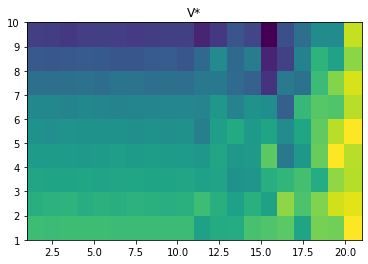

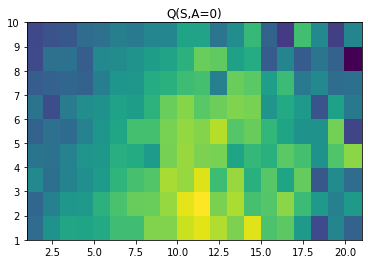

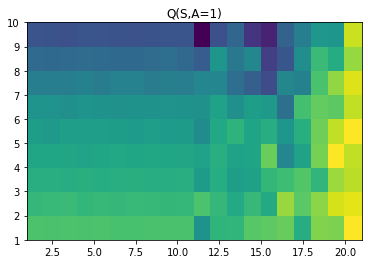

In [10]:
run_monte_carlo()

## TD learning in easy 21

I implemented TD(0) and TD($\lambda$)

In [11]:
def run_sarsa():
    #init env
    env = Easy21()

    #init agent
    agent = AgentEpsilonTable(env.action_space,10,21,100)

    number_of_episodes=200000
    #bootstappig episodes
    for episode in tqdm(range(number_of_episodes)):
        state = env.restart()
        done = False
        while not done:
            action = agent.select_action(state)
            new_state, reward, done = env.step(action)

            #online updates
            if new_state is None:
                rtn = reward
            else:
                rtn = reward+ np.max(agent.q_table[new_state[0]-1,new_state[1]-1])
            agent.update_q_value(state,action,rtn)
            state=new_state
    
    #plot Q table
    plot_q_table(agent.q_table)


def run_sarsa_lambda():
    #initialize env
    env = Easy21()

    #initialize Q table
    agent = AgentEpsilonTable(env.action_space,10,21,100)

    number_of_episodes=2000000

    
    #lambda for the algorithm to weight the relevance of the 
    lmba=0.5

    for episode in tqdm(range(number_of_episodes)):
        state = env.restart()
        done = False
        history = []
        while not done:
            action = agent.select_action(state)
            new_state, reward, done = env.step(action)
            history.append((state,action,reward))
            state=new_state
        #offline updates using sarsa lambda
        for i in range(len(history)):
            states,actions,rewards = zip(*history[i:])

            #computation of the returns
            rtns=[]
            for k in range(len(rewards)):
                if k+1<len(rewards):
                    current_state = states[k+1]
                    rtn = sum(rewards[:k+1]) + np.max(agent.q_table[current_state[0]-1,current_state[1]-1])
                    rtns.append(rtn*lmba**k)
                if (k+1) == len(rewards):
                    rtn=sum(rewards)
                    rtns.append(rtn*lmba**k)
            #summing and normalizing the lambda returns
            rtn = sum(rtns)*(1-lmba)/(1-lmba**(len(rtns)))
            state,action,_ = history[i]
            #updating Q value
            agent.update_q_value(state,action,rtn)



    #plot Q table
    plot_q_table(agent.q_table)


100%|██████████| 2000000/2000000 [03:00<00:00, 11052.63it/s]


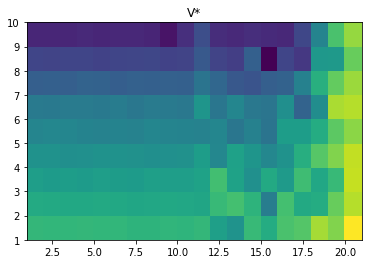

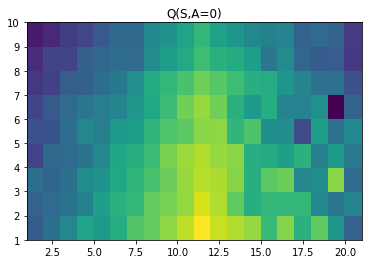

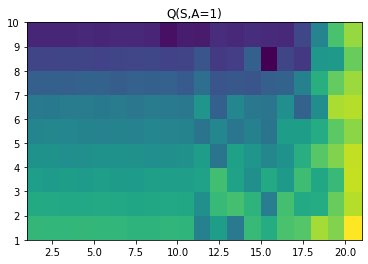

In [12]:
run_sarsa_lambda()

## Linear Function Approximation in Easy21
There is a dedicated property in the Easy21 class that returns a binary state made explicitely for the function approximator agent 

In [13]:

#Agent implementing linear sarsa using numpy
class AgentSarsaNumpy(object):
    """
    This Agent implements a linear combination of features + action therefore the Q value
    is evaluated for each action possible performing a forward computation
    """
    def __init__(self,state_dim,action_dim,epsilon,epsilon_decay):
        self.weights = np.random.randn(1,state_dim+1)
        self.bias = np.random.randn(1)
        self.action_dim = action_dim
        self._epsilon = epsilon
        self.epsilon_decay=epsilon_decay
        self.time=0


    #decaying epsilon
    @property
    def epsilon(self):
        return self._epsilon*self.epsilon_decay**self.time

    #function to process state + action
    def process(self,x):
        return np.dot(x,np.transpose(self.weights))+self.bias

    
    #function to process a state
    def forward(self,state):
        actions_null=np.zeros((*state.shape[:-1],1))
        actions_ones = np.ones((*state.shape[:-1],1))
        vector_action_0 = np.concatenate((state,actions_null),axis=-1)
        vector_action_1 = np.concatenate((state,actions_ones),axis=-1)

        return np.concatenate((self.process(vector_action_0),self.process(vector_action_1)),axis=-1)

    def select_action(self,state):
        if random.random() < self.epsilon:
            return random.choice(range(self.action_dim-1))
        else:
            return np.argmax(self.forward(state))
    #decay the epsilon
    def decay(self):
        self.time+=1

    #update the Q value estimated using linear sarsa , the targets being the MC, TD target
    def update_q_model(self,states,actions,targets,learning_rate):
        a = actions.reshape(*states.shape[:-1],1)
        vector_values = np.concatenate((states,a),axis=-1)
        estimated_value = self.process(vector_values)
        errors = np.mean(estimated_value -targets)
        self.weights -= learning_rate*errors*self.weights
        self.bias -= learning_rate*errors
        return errors


In [24]:
#function using a simpler binary representation of the game to feed a function approximator
def run_approximator():
    #init env
    env = Easy21()
    #intialize agent approximator
    agent = AgentSarsaNumpy(9,2,0.95,0.99)
    #lambda for the sarsa lambda algorithm
    lmba=0.5
    #learning rate for the gradient descent
    learning_rate = 0.001


    number_of_episodes=60000

    #TD errors for the plots
    errors=[]

    for episode in tqdm(range(number_of_episodes)):
        env.restart()
        #we are taking the binary state here
        state = env.binary_state
        done = False
        history = []
        while not done:
            action = agent.select_action(state)
            _, reward, done = env.step(action)
            new_state = env.binary_state
            history.append((state,action,reward))
            state=new_state
        #offline sarsa lambda updates (forward view)
        targets = []
        for i in range(len(history)):
            states,actions,rewards = zip(*history[i:])
            rtns=[]
            for k in range(len(rewards)):
                if k+1<len(rewards):
                    current_state = states[k+1]
                    rtn = sum(rewards[:k+1]) + np.max(agent.forward(current_state))
                    rtns.append(rtn*lmba**k)
                if (k+1) == len(rewards):
                    rtn=sum(rewards)
                    rtns.append(rtn*lmba**k)

            rtn = sum(rtns)*(1-lmba)/(1-lmba**(len(rtns)))
            targets.append(rtn)
        states,actions,rewards = zip(*history)
        #updating model (the update function returns the TD error)
        errors.append(abs(agent.update_q_model(np.stack(states),np.array(actions),np.array(targets),learning_rate)))
        #decaying epsilon
        agent.decay()
    plt.plot(np.mean(np.array(errors).reshape(-1,1000),axis=1))
    plt.xlabel("Iteration")
    plt.ylabel("Square Error")
    plt.show()


100%|██████████| 60000/60000 [01:17<00:00, 772.57it/s]


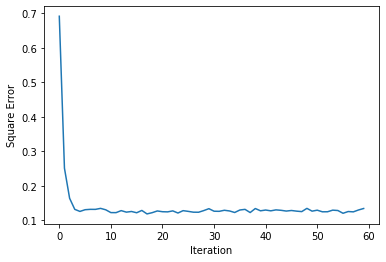

In [25]:
run_approximator()